In [2]:
import os
import yaml

# from utils.models.interaction_network import InteractionNetwork
from utils.hls4ml.load_torch import load_graphs, load_models
from utils.hls4ml.compare import compare_hls4ml

In [14]:
import os
import numpy as np
from copy import deepcopy
from prettytable import PrettyTable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from collections import namedtuple, OrderedDict
from utils.data.graphdata import GraphDataset
from utils.hls4ml.fix_graph_size import fix_graph_size
from utils.hls4ml.wrappers import data_wrapper, model_wrapper


from hls4ml.utils.config import config_from_pyg_model
from hls4ml.converters import convert_from_pyg_model

from abdel.utils.models.interaction_network_pyg import InteractionNetwork

import matplotlib.pyplot as plt
%matplotlib inline
from utils.hls4ml import plotting

def load_graphs(graph_indir, out_dir, graph_dims, n_graphs):
    
    n_node_max = graph_dims['n_node']
    n_edge_max = graph_dims['n_edge']
    
    Graph = namedtuple('Graph', ['x', 'edge_attr', 'edge_index', 'y', 'pid'])
    graph_files = np.array(os.listdir(graph_indir))
    graph_files = np.array([os.path.join(graph_indir, graph_file) for graph_file in graph_files])
    
    graphs = []
    n_nodes, n_edges = [], []
    
    for file in graph_files[:n_graphs]:
        x, edge_attr, edge_index, y, pid = np.load(file, allow_pickle=True)
        G = Graph(x, edge_attr, edge_index, y, pid)
        graphs.append(G)
        n_nodes.append(len(x))
        n_edges.append(len(y))
        
    dataset = GraphDataset(graphs)
    
    graphs = []
    for data in dataset[:n_graphs]:
        node_attr, edge_attr, edge_index, target, bad_graph = fix_graph_size(data, n_node_max, n_edge_max)
        if not bad_graph:
            graphs.append(data_wrapper(node_attr, edge_attr, edge_index, target))
    print(f"n_graphs: {len(graphs)}")
            
    nodes_kept = np.sum([n<n_node_max for n in n_nodes])
    edges_kept = np.sum([e<n_edge_max for e in n_edges])
    
    print(f'node dimension: {node_attr.shape}, edge dimension: {edge_attr.shape}')
    print(f'{nodes_kept/n_graphs:.1%} of graphs without truncation of nodes')
    print(f'{edges_kept/n_graphs:.1%} of graphs without truncation of edges')
 

    print("writing test bench data for 1st graph")
    data = graphs[0]
    node_attr, edge_attr, edge_index = data.x.detach().cpu().numpy(), data.edge_attr.detach().cpu().numpy(), data.edge_index.transpose(
        0, 1).detach().cpu().numpy().astype(np.int32)
    os.makedirs('tb_data', exist_ok=True)
    input_data = np.concatenate([node_attr.reshape(1, -1), edge_attr.reshape(1, -1), edge_index.reshape(1, -1)], axis=1)
    np.savetxt('tb_data/input_data.dat', input_data, fmt='%f', delimiter=' ')

    return graphs



def load_models(model_dir, output_dir, n_neurons, precision, reuse, part, graph_dims, hls_only=True):
    
    if 'dict' in model_dir:
        torch_model = InteractionNetwork(hidden_size=n_neurons)
        torch_model_dict = torch.load(model_dir)
        torch_model_dict = deepcopy(torch_model_dict)
        torch_model.load_state_dict(torch_model_dict)
    else:
        torch_model = torch.load(model_dir)
        
    torch_model.eval()

    forward_dict = OrderedDict()
    forward_dict["R1"] = "EdgeBlock"
    forward_dict["O"] = "NodeBlock"
    forward_dict["R2"] = "EdgeBlock"
    

    # get hls model
    config = config_from_pyg_model(torch_model,
                                   default_precision=precision,
                                   default_index_precision='ap_uint<16>', 
                                   default_reuse_factor=reuse)
        
    print("-----------------------------------")
    plotting.print_dict(config)
    print("-----------------------------------")


    
    %matplotlib inline
    for layer in config['LayerName'].keys():
        config['LayerName'][layer]['Trace'] = True
    hls_model = hls4ml.converters.convert_from_pyg_model(model,
                                                           hls_config=config,
                                                           output_dir='hls_output/profiling/hls4ml_prj_2',
                                                           part='xczu9eg-ffvb1156-2-e')
    hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=graphs[:10])
    
    
    return 0
    
    
#     hls_model = convert_from_pyg_model(torch_model,
#                                        forward_dictionary=forward_dict,
#                                        **graph_dims,
#                                        activate_final="sigmoid",
#                                        output_dir=output_dir,
#                                        hls_config=config,
#                                        part=part
#                                        )
#     hls_model.compile()
    
#     if hls_only:
#         return hls_model
    
#     else:
#         torch_wrapper = model_wrapper(torch_model)
#         return torch_model, hls_model, torch_wrapper

# Load graph data (100 events)
Truncate node and edge size at 95% of sizes of all events

In [7]:
graph_indir = 'data/graphs'
output_dir = 'hls_output/simulation'

graph_dims = {
    "n_node": 50,
    "n_edge": 60,
    "node_dim": 3,
    "edge_dim": 4
}

graphs = load_graphs(graph_indir, output_dir, graph_dims, 100)

n_graphs: 13
node dimension: torch.Size([50, 3]), edge dimension: torch.Size([60, 4])
3.0% of graphs without truncation of nodes
1.0% of graphs without truncation of edges
writing test bench data for 1st graph


# Load model and compile hls model

In [15]:
nevents = 1000
trained_model_dir = f'models/IN_trained_events_{nevents}_neurons_8_state_dict.pt'
precision = 'ap_fixed<16,8>'
index_precision = 'ap_uint<8>'
reuse = 1
part = 'xcvc1902-vsva2197-2MP-e-S'
n_neurons=8

# graph_dims = {
#     "n_node": node_shape[0],
#     "n_edge": edge_shape[0],
#     "node_dim": node_shape[1],
#     "edge_dim": edge_shape[1]
# }

torch_model, hls_model, torch_wrapper = load_models(trained_model_dir, output_dir, n_neurons, precision, reuse, part,graph_dims, hls_only=False)
torch_model.count_parameters()

print("Model compiled at: ", hls_model.config.get_output_dir())
model_config = f"precision: {precision} \nreuse_factor: {reuse}"
with open(hls_model.config.get_output_dir() + "//model_config.txt", "w") as file:
    file.write(model_config)

-----------------------------------
Model
  Precision:         ap_fixed<16,8>
  IndexPrecision:    ap_uint<16>
  ReuseFactor:       1
  Strategy:          Latency
-----------------------------------


KeyError: 'LayerName'

# Compare metrics

In [4]:
all_torch_error, all_hls_error, all_torch_hls_diff, wrapper_MAE, hls_output = compare_hls4ml(graphs, output_dir, torch_model, hls_model, torch_wrapper, all_metrics=True)

     single-graph wrapper-->torch MAE: 3.6942367387382546e-08

     with error criteria = MAE:
          mean torch error: 0.06953571
          mean hls error: 0.07183308
          mean hls-->torch error: 0.007476559

     with error criteria = MSE:
          mean torch error: 0.034427207
          mean hls error: 0.03577862
          mean hls-->torch error: 0.0015801615

     with error criteria = RMSE:
          mean torch error: 0.16716947
          mean hls error: 0.17189424
          mean hls-->torch error: 0.025338326

     with score criteria = Accuracy:
          mean torch score: 0.9535268287326792
          mean hls score: 0.9510748297103195
          mean hls-->torch score: 0.9928910433899946

     with score criteria = f1:
          mean torch score: 0.9532767798570513
          mean hls score: 0.9509780794258036
          mean hls-->torch score: 0.9933260336450692

     with score criteria = AUC:
          mean torch score: 0.9858453661217268
          mean hls score: 0.98

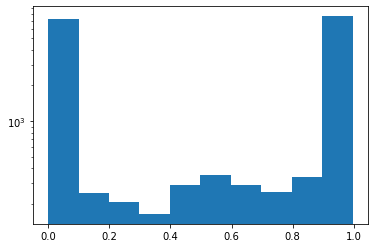

In [5]:
import matplotlib.pyplot as plt
plt.hist(hls_output)
plt.yscale('log')

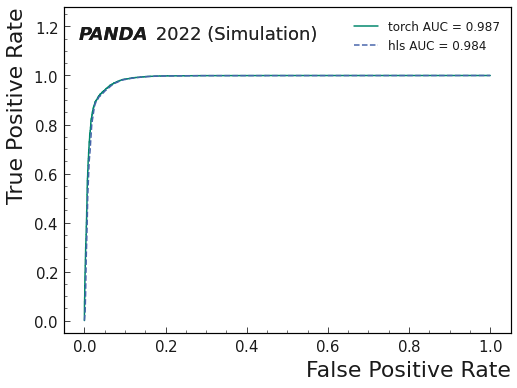

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from utils.plotting.plot import watermark

torch_roc = all_torch_error['ROC']
hls_roc = all_hls_error['ROC']

def plot_roc(roc, label):
    plt.style.use("kit")
    fpr, tpr, thresholds = roc
    auc_val=auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label} AUC = {auc_val:.3f}', marker='None')
    
    watermark(py=0.9, shift=0.16, scale=1.1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='center right', bbox_to_anchor=(1, 0.91), fontsize=12)

plt.figure(figsize=(8,6))
plot_roc(torch_roc, 'torch')    
plot_roc(hls_roc, 'hls')
plt.savefig('img/hls_roc_plot.png', bbox_inches='tight')
plt.show()



# Compare for different floating point sizes

In [7]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")  


bits = [8,12,16,20,24]
rocs=[]

for b in tqdm(bits):
    precision = f'ap_fixed<{b},{int(b/2)}>'
    model_dir = 'models/trained_IN_neurons_8.pt'
    output_dir = f"hls_output/precision_{b}"
    index_precision = 'ap_uint<8>'
    reuse = 1
    part = 'xcvu9p-flga2104-2L-e'

    torch_model, hls_model, torch_wrapper = load_models(trained_model_dir, output_dir, n_neurons, precision, reuse, part,graph_dims, hls_only=False)
    hls_model.compile()
    all_torch_error, all_hls_error, all_torch_hls_diff, _, _ = compare_hls4ml(graphs, output_dir, torch_model, hls_model, torch_wrapper, all_metrics=True)
    hls_roc = all_hls_error['ROC'] 
    rocs.append(hls_roc)

  0%|                                                                                                                                                                  | 0/5 [00:00<?, ?it/s]

Writing HLS project
Done
Writing HLS project
Done


 20%|██████████████████████████████▊                                                                                                                           | 1/5 [00:12<00:49, 12.48s/it]

     single-graph wrapper-->torch MAE: 3.6942367387382546e-08

     with error criteria = MAE:
          mean torch error: 0.06953571
          mean hls error: 0.552273
          mean hls-->torch error: 0.5228192

     with error criteria = MSE:
          mean torch error: 0.034427207
          mean hls error: 0.42594463
          mean hls-->torch error: 0.38785723

     with error criteria = RMSE:
          mean torch error: 0.16716947
          mean hls error: 0.6514438
          mean hls-->torch error: 0.6212874

     with score criteria = Accuracy:
          mean torch score: 0.9535268287326792
          mean hls score: 0.43998403931762387
          mean hls-->torch score: 0.43678347162630565

     with score criteria = f1:
          mean torch score: 0.9532767798570513
          mean hls score: 0.36600574729379737
          mean hls-->torch score: 0.3681327830893359

     with score criteria = AUC:
          mean torch score: 0.9858453661217268
          mean hls score: 0.41976245

 40%|█████████████████████████████████████████████████████████████▌                                                                                            | 2/5 [00:24<00:35, 11.95s/it]

     single-graph wrapper-->torch MAE: 3.6942367387382546e-08

     with error criteria = MAE:
          mean torch error: 0.06953571
          mean hls error: 0.15452397
          mean hls-->torch error: 0.10305499

     with error criteria = MSE:
          mean torch error: 0.034427207
          mean hls error: 0.0929012
          mean hls-->torch error: 0.058258288

     with error criteria = RMSE:
          mean torch error: 0.16716947
          mean hls error: 0.29856637
          mean hls-->torch error: 0.23194312

     with score criteria = Accuracy:
          mean torch score: 0.9535268287326792
          mean hls score: 0.8732552702413438
          mean hls-->torch score: 0.899226973165427

     with score criteria = f1:
          mean torch score: 0.9532767798570513
          mean hls score: 0.8810429160365798
          mean hls-->torch score: 0.9080092036965864

     with score criteria = AUC:
          mean torch score: 0.9858453661217268
          mean hls score: 0.9164618

 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 3/5 [00:34<00:22, 11.34s/it]

     single-graph wrapper-->torch MAE: 3.6942367387382546e-08

     with error criteria = MAE:
          mean torch error: 0.06953571
          mean hls error: 0.07183308
          mean hls-->torch error: 0.007476559

     with error criteria = MSE:
          mean torch error: 0.034427207
          mean hls error: 0.03577862
          mean hls-->torch error: 0.0015801615

     with error criteria = RMSE:
          mean torch error: 0.16716947
          mean hls error: 0.17189424
          mean hls-->torch error: 0.025338326

     with score criteria = Accuracy:
          mean torch score: 0.9535268287326792
          mean hls score: 0.9510748297103195
          mean hls-->torch score: 0.9928910433899946

     with score criteria = f1:
          mean torch score: 0.9532767798570513
          mean hls score: 0.9509780794258036
          mean hls-->torch score: 0.9933260336450692

     with score criteria = AUC:
          mean torch score: 0.9858453661217268
          mean hls score: 0.98

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4/5 [00:45<00:11, 11.15s/it]

     single-graph wrapper-->torch MAE: 3.6942367387382546e-08

     with error criteria = MAE:
          mean torch error: 0.06953571
          mean hls error: 0.069724
          mean hls-->torch error: 0.0013600728

     with error criteria = MSE:
          mean torch error: 0.034427207
          mean hls error: 0.034384955
          mean hls-->torch error: 1.2091962e-05

     with error criteria = RMSE:
          mean torch error: 0.16716947
          mean hls error: 0.1671469
          mean hls-->torch error: 0.0030953682

     with score criteria = Accuracy:
          mean torch score: 0.9535268287326792
          mean hls score: 0.9530785023015553
          mean hls-->torch score: 0.9986493194836571

     with score criteria = f1:
          mean torch score: 0.9532767798570513
          mean hls score: 0.9528123112488591
          mean hls-->torch score: 0.9987186603737889

     with score criteria = AUC:
          mean torch score: 0.9858453661217268
          mean hls score: 0.9

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.28s/it]

     single-graph wrapper-->torch MAE: 3.6942367387382546e-08

     with error criteria = MAE:
          mean torch error: 0.06953571
          mean hls error: 0.069766656
          mean hls-->torch error: 0.0007408562

     with error criteria = MSE:
          mean torch error: 0.034427207
          mean hls error: 0.034427825
          mean hls-->torch error: 1.6575567e-06

     with error criteria = RMSE:
          mean torch error: 0.16716947
          mean hls error: 0.16724958
          mean hls-->torch error: 0.0012053325

     with score criteria = Accuracy:
          mean torch score: 0.9535268287326792
          mean hls score: 0.9532067874940946
          mean hls-->torch score: 0.9991191811002156

     with score criteria = f1:
          mean torch score: 0.9532767798570513
          mean hls score: 0.9529130339057028
          mean hls-->torch score: 0.9991640893121169

     with score criteria = AUC:
          mean torch score: 0.9858453661217268
          mean hls score:

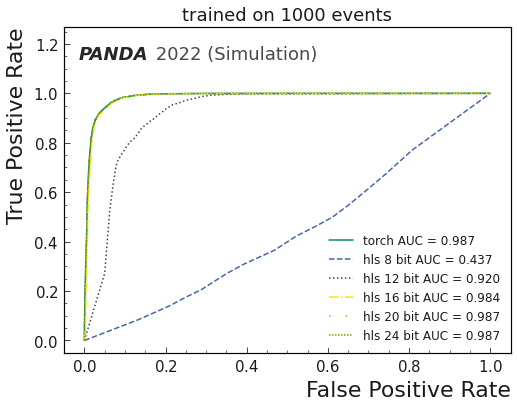

In [8]:
def plot_roc(roc, label):
    plt.style.use("kit")
    fpr, tpr, thresholds = roc
    auc_val=auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label} AUC = {auc_val:.3f}', marker='None')
    
plot_roc(torch_roc, 'torch') 
for i,b in enumerate(bits):
    
    plot_roc(rocs[i], f'hls {b} bit')

watermark(py=0.9, shift=0.16, scale=1.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'trained on {nevents} events')
plt.legend(loc='lower right', fontsize=12, frameon = True, framealpha = 0.7, facecolor = 'white', edgecolor = 'white')
plt.savefig(f'img/hls_roc_plot_ngraphs_{nevents}.png', bbox_inches='tight')
plt.show()

# Build HLS

In [9]:
# hls4ml.report.read_vivado_report('hls_output/test/')